In [1]:
import functions as fct
import pandas as pd
import dynamics as dyn
import numpy as np
import dask
from cluster import new_launch_cluster
import graphics as gx

# parameter setting
nb_banks=100
path = "./results/parameter_space/test_beta/"
initial_deposits_size = 40

# reg ratios
alpha_init=False  # initial cash (< 1/(1-gamma) - beta)
alpha=0.01
beta_init=0.5 # initial collateral  (< 1/(1-gamma) - alpha)
beta_reg=0.5
beta_star=0.5
gamma=0.03
gamma_init = 3*gamma
collateral_value=1.0

# initialisation of deposits size
initialization_method="pareto"
alpha_pareto=1.4

# shocks on deposits 
shocks_method="non-conservative"
shocks_law="normal-mean-reverting"
shocks_vol=0.08 # 0.05

# speed of learning
learning_speed = 0.5

# min trans size
min_repo_trans_size=1e-8  # 1e-8

# dynamics & ploting
nb_steps=int(10e3)
dump_period=int(5e3)
plot_period=int(5e3)
cp_option=True
heavy_plot=False

# LCR mgt
LCR_mgt_opt=True

# leverage mgt
end_repo_period=False # if int, periodic end repo / if false, leverage mgt
gamma_star = 1.5*gamma
check_leverage_opt = False # to avoid killing the run if one or several banks are below min leverage due to high shocks (there is not possibility of decrease balance sheet size if no interbank borrowings)

# money creation
loan_tenor=nb_steps # if int, money creation / if false. no new loans
loan_period=1
new_loans_vol = 0 # standard deviation around the mean creation of loans
new_loans_mean = 2e-2/250 # daily mean increase in loans expressed as a percentage of the intital loans (the other option would be a relative increase but it is unstable np.exp(np.log(1.01)/250)-1 = 4e-5)
beta_new = beta_reg # if number, new colat / if false, no new colat 
# gamma_new = gamma_star*(beta_reg+1)/(1+gamma_star*beta_reg) # if number, new own funds / if false, no new own funds. we need to also add beta reg to ensure LCR can be covered with additional cash (and we still match the solvency ratio despite this excess of stress) in the case of no payment shocks and no collateral creation
gamma_new = 3*gamma
init_money_min = 1e-2 # 10 million money units, minimum for a bank license

# substitution of collateral
substitution = False

# Quantitative easing scenario
QE_start = False
QE_stop = False

# GFC scenario
no_trust_start = False
no_trust_stop = False

dic_default_value = {
    "nb_banks": nb_banks,
    "initial_deposits_size": initial_deposits_size,
    "alpha_init": alpha_init,
    "alpha": alpha,
    "beta_init": beta_init,
    "beta_reg": beta_reg,
    "beta_star": beta_star,
    "beta_new": beta_new,
    "gamma_init": gamma_init,
    "gamma": gamma,
    "gamma_star": gamma_star, 
    "gamma_new": gamma_new, 
    "collateral_value": collateral_value,
    "initialization_method": initialization_method,
    "alpha_pareto": alpha_pareto,
    "shocks_method": shocks_method,
    "shocks_law": shocks_law,
    "shocks_vol": shocks_vol,
    "LCR_mgt_opt": LCR_mgt_opt,
    "min_repo_trans_size": min_repo_trans_size,
    "loan_tenor": loan_tenor, # for money creation 
    "loan_period": loan_period,
    "new_loans_vol": new_loans_vol,
    "new_loans_mean": new_loans_mean,
    "end_repo_period": end_repo_period,
    "nb_steps": nb_steps,
    "path_results": f"{path}runs/",
    "dump_period": dump_period,
    "plot_period": plot_period,
    "cp_option": cp_option,
    "heavy_plot": heavy_plot,  # False to avoid the number of linux node to explode
    "substitution":substitution,
    "learning_speed":learning_speed,
    "check_leverage_opt":check_leverage_opt,
    "init_money_min":init_money_min,
    "QE_start":QE_start,
    "QE_stop":QE_stop,
    "no_trust_start":no_trust_start,
    "no_trust_stop":no_trust_stop,
}

# special dictionary of parameters ranges 
list_dic_range = [
    # {"nb_banks":  [_ for _ in np.arange(50, 550,50)]*20},
    # {"alpha_pareto": [_ for _ in np.logspace(0,2,100)*0.4]*100,},
    # {"gamma_new": [_ for _ in np.arange(1, 2,0.01)*gamma_star]*100,
    #  "gamma_init": [_ for _ in np.arange(1, 2,0.01)*gamma_star]*100
    #  },
    # {"learning_speed": [_ for _ in np.logspace(-5,0,100)]*50 + [0]*100}, 
    # {"shocks_vol":  [_ for _ in np.arange(0, 0.30, 0.003)]*100},
    {"beta_reg": [_ for _ in np.arange(0, 1,0.01)]*100,
     "beta_star": [_ for _ in np.arange(0, 1,0.01)]*100,
     "beta_new": [_ for _ in np.arange(0, 1,0.01)]*100,
     "beta_init": [_ for _ in np.arange(0, 1,0.01)]*100,
     },
]

In [4]:
# # initialize the path
# fct.delete_n_init_path(path)

# run parameter space analysis

In [2]:
# build list of the dic_args to be tested
list_dic_args = fct.build_args(dic_default_value, list_dic_range)

# open a cluster
client, cluster = new_launch_cluster(
    task_memory=19,
    job_walltime="72:00:00",
    max_cpu=len(list_dic_args),
)

# run with dask distributed
dld_obj = [
    dask.delayed(dyn.single_run)(**dic_args) for dic_args in list_dic_args
]
futures = client.compute(dld_obj)


/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45602 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.70.211.9:45602/status,
Dashboard: http://10.70.211.9:45602/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.70.211.9:41403,Workers: 0
Dashboard: http://10.70.211.9:45602/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
! squeue -u vlecoz -h -t pending,running -r -O "state" | uniq -c

In [3]:
from tqdm import tqdm

# store error types
sr_dask_finished = pd.Series()
for i, future in enumerate(tqdm(futures)):
    if future.status == "finished":
        sr_dask_finished.loc[i] = str(future.result())

NameError: name 'pd' is not defined

In [8]:
sr_dask_finished.dropna().apply(lambda x: x[:50]).value_counts()

***ERROR***: bank 92 has not enough collateral to     2
***ERROR***: bank 49 has not enough collateral to     2
***ERROR***: bank 45 has not enough collateral to     2
***ERROR***: bank 4 has not enough collateral to e    1
***ERROR***: bank 78 has not enough collateral to     1
***ERROR***: bank 56 has not enough collateral to     1
***ERROR***: bank 24 has not enough collateral to     1
***ERROR***: bank 79 has not enough collateral to     1
***ERROR***: bank 96 has not enough collateral to     1
***ERROR***: bank 46 has not enough collateral to     1
***ERROR***: bank 67 has not enough collateral to     1
***ERROR***: securities reused negative -591.36635    1
***ERROR***: bank 33 has not enough collateral to     1
***ERROR***: bank 90 has not enough collateral to     1
***ERROR***: bank 7 has not enough collateral to e    1
***ERROR***: bank 48 has not enough collateral to     1
***ERROR***: bank 83 has not enough collateral to     1
***ERROR***: bank 39 has not enough collateral t

In [2]:
futures[0].result()

NameError: name 'futures' is not defined

In [1]:
from tqdm import tqdm

# store error types
sr_dask_errors = pd.Series()
for i, future in enumerate(tqdm(futures)):
    if future.status == "error":
        sr_dask_errors.loc[i] = str(future.exception())

NameError: name 'pd' is not defined

In [9]:
sr_dask_errors[18]

"[Errno 2] No such file or directory: './results/parameter_space/test/runs/alpha_pareto/18#0.924051880033264/input_parameters.txt'"

In [5]:
# look at the different types of dask errors
sr_dask_errors.dropna().apply(lambda x: x[:300]).value_counts()

__init__() missing 5 required positional arguments: 'init_money_min', 'QE_start', 'QE_stop', 'no_trust_start', and 'no_trust_stop'    35100
dtype: int64

In [5]:
# check the logs saved, look for what appended to the died workers
import os
sr_logs =pd.Series()
path_logs = f"./dask_logs/D2024-06_21_T18-05-55.472605/"
files = os.listdir(path_logs)
for file in tqdm(files):
    sr_logs.loc[file]= open(f"{path_logs}/{file}", "r").read()

/opt/tmp/tmp/ipykernel_214199/1202213659.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr_logs =pd.Series()
100%|██████████| 332/332 [01:22<00:00,  4.03it/s]


In [167]:
sr_bool = sr_logs.str.contains('tcp://10.67.203.13:44700', na=False, regex=True)
sr_bool.loc[sr_bool]

dask-worker-12488587.err    True
dtype: bool

In [7]:
15000/320

46.875

In [ ]:
client.shutdown()

In [4]:
if "client" in globals():
    client.close()
    cluster.close()
    client.shutdown()

# collect results

In [ ]:
# collect results into df_network_sensitivity
df_network_sensitivity, sr_errors = fct.get_df_network_sensitivity(dic_default_value["path_results"])

In [10]:
 # look at the different types of errors
sr_bool_error = sr_errors.str.contains("ERROR", na=False, regex=True)
sr_errors[sr_bool_error].apply(lambda x: (x.split("***ERROR***:"))[1][:25]).value_counts()

 securities reused negati    141
 bank 61 has not enough c     30
 bank 29 has not enough c     29
 bank 62 has not enough c     28
 bank 17 has not enough c     27
                            ... 
 bank 78 has not enough c     12
 bank 55 has not enough c     11
 bank 99 has not enough c     10
 bank 22 has not enough c      9
 bank 18 has not enough c      8
Length: 101, dtype: int64

In [9]:
sr_errors[sr_errors.str.contains("assets don't", na=False, regex=True)]

Series([], dtype: object)

# plot results

In [4]:
import functions as fct
import pandas as pd
import dynamics as dyn
import numpy as np
import dask
from cluster import new_launch_cluster
import graphics as gx

path = "./results/parameter_space/test_beta/"

# plot the sensitivity
df_network_sensitivity = pd.read_csv(f"{dic_default_value['path_results']}df_network_sensitivity.csv", index_col=(0,1,2))
gx.plot_all_sensitivities(df_network_sensitivity,path=path)

<AxesSubplot: >

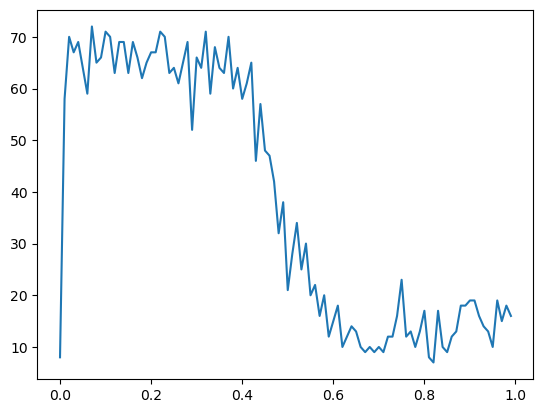

In [5]:
df_network_sensitivity.loc["beta_reg"]["cash tot. network"].isna().groupby(level=0).sum().plot()

# collect error or completed files

In [3]:
import os
import pandas as pd
from pathlib import Path
df_stats = pd.DataFrame()
for param_path in os.listdir(f"{path}runs"):
    if os.path.isdir(f"{path}runs/{param_path}/"):
        for run_path in os.listdir(f"{path}runs/{param_path}/"):
            df_stats.loc[run_path,param_path] =  Path(f"{path}runs/{param_path}/{run_path}/completed.txt").is_file()
            
            

In [4]:
df_stats.sum()

shocks_vol        5150
alpha_pareto      8264
beta_reg          1265
learning_speed    4062
gamma_new         8471
dtype: object

In [11]:
for ranges in list_dic_range:
    print(len(list(ranges.values())[0]))

10000
10000
5100
10000
10000


In [12]:
for ranges in list_dic_range:
    print(ranges.keys())

dict_keys(['alpha_pareto'])
dict_keys(['gamma_new', 'gamma_init'])
dict_keys(['learning_speed'])
dict_keys(['shocks_vol'])
dict_keys(['beta_reg', 'beta_star'])


In [3]:
path = "./results/parameter_space/test/"

# delete un-necessary files

In [4]:
import os
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import functions as fct
for param_path in os.listdir(f"{path}runs"):
    if os.path.isdir(f"{path}runs/{param_path}/"):
        for run_path in tqdm(os.listdir(f"{path}runs/{param_path}/")):
            if Path(f"{path}runs/{param_path}/{run_path}/completed.txt").is_file():
                
                # load the existing df_network_trajectory file
                path_df = f"{path}runs/{param_path}/{run_path}/df_network_trajectory.csv"
                df_network_trajectory = pd.read_csv(path_df, index_col=0)
                
                # delete everything                
                fct.delete_n_init_path(f"{path}runs/{param_path}/{run_path}")

                
                # re-save the necessary files
                df_network_trajectory.to_csv(f"{path}runs/{param_path}/{run_path}/df_network_trajectory.csv")
                
                with open(f"{path}runs/{param_path}/{run_path}/completed.txt", "w") as f:
                    f.write(f"Completed !")

  0%|          | 0/10000 [00:00<?, ?it/s]

 28%|██▊       | 2846/10000 [20:27<1:12:06,  1.65it/s]/tmp/ipykernel_22012/1260053924.py:13: DtypeWarning: Columns (46,47,48,49,50,51,52,53,54,55,56,57,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_network_trajectory = pd.read_csv(path_df, index_col=0)
 43%|████▎     | 4301/10000 [30:36<52:45,  1.80it/s]  /tmp/ipykernel_22012/1260053924.py:13: DtypeWarning: Columns (46,47,48,49,50,51,52,53,54,55,56,57,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_network_trajectory = pd.read_csv(path_df, index_col=0)
 55%|█████▌    | 5517/10000 [39:23<44:27,  1.68it/s]  /tmp/ipykernel_22012/1260053924.py:13: DtypeWarning: Columns (46,47,48,49,50,51,52,53,54,55,56,57,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_network_trajectory = pd.read_csv(path_df, index_col=0)
 61%|██████    | 6083/10000 [43:13<20:18,  3.22it/s]/tmp/ipykernel_22012/1260053924.py:13: DtypeWarning: Columns